# GOAL

This script aims to compare the plot of ghi and power of a day where Naomi and Tim do not agree whether it is a clear sky day or not. In her paper, Naomi says she is using a visual inspection, while Tim judges a clear sky day by its GHI profile.

# NAOMI CSD LIST

In [ ]:
naomi_csd = [
'2019-09-12',
'2019-09-17', 
'2019-10-01',
'2019-10-02',
'2019-11-18',
'2019-11-27',
'2019-12-16',
'2019-12-19',
'2019-12-25',
'2020-01-01',
'2020-01-02',
'2020-01-06',
'2020-01-07',
'2020-01-08',
'2020-01-12',
'2020-01-13',
'2020-01-14',
'2020-01-29',
'2020-01-30',
'2020-02-04',
'2020-02-05',
'2020-02-06',
'2020-02-10',
'2020-02-11',
'2020-02-22',
'2020-03-08',
'2020-03-15',
'2020-03-25',
'2020-03-26',
'2020-04-09',
'2020-04-13',
'2020-04-24',
]

# TIM CSD LIST

In [ ]:
csd_201909 = ['2019-09-12', '2019-09-17', '2019-09-18', '2019-09-26', '2019-09-29', '2019-09-30']
csd_201910 = ['2019-10-01', '2019-10-02', '2019-10-03', '2019-10-29']
csd_201911 = ['2019-11-18', '2019-11-27']
csd_201912 = ['2019-12-16', '2019-12-19', '2019-12-25', '2019-12-28']
csd_202001 = ['2020-01-01', '2020-01-02', '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-12', '2020-01-13', '2020-01-14', '2020-01-17', '2020-01-29', '2020-01-30']
csd_202002 = ['2020-02-04', '2020-02-05', '2020-02-06', '2020-02-10', '2020-02-11', '2020-02-13', '2020-02-22', '2020-02-23']
csd_202003 = ['2020-03-03', '2020-03-08', '2020-03-10', '2020-03-14', '2020-03-15', '2020-03-25', '2020-03-26']
csd_202004 = ['2020-04-08', '2020-04-09', '2020-04-13', '2020-04-24']

tim_csd = csd_201909 + csd_201910 + csd_201911 + csd_201912 + csd_202001 + csd_202002 + csd_202003 + csd_202004

# SAMPLE TAKING

In [ ]:
naomi_csd_tim_notcsd = list(set(naomi_csd).difference(set(tim_csd)))

In [ ]:
tim_csd_naomi_notcsd = list(set(tim_csd).difference(set(naomi_csd)))

In [ ]:
tim_csd_naomi_notcsd

In [ ]:
len(tim_csd_naomi_notcsd)

In [ ]:
tim_csd_naomi_notcsd = [
 '2019-09-18',
 '2019-09-26',
 '2019-09-29',
 '2019-09-30',
 '2019-10-03',
 '2019-10-29',
 '2019-12-28',
 '2020-01-17',
 '2020-02-13',
 '2020-02-23',
 '2020-03-03',
 '2020-03-10',
 '2020-03-14',
 '2020-04-08',
 ]

In [ ]:
len(tim_csd_naomi_notcsd)

# ANALYSIS

In [21]:
#IMPORT PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pytz #for timezone calculation
import math
import matplotlib.dates as md
import gc
import os
from datetime import datetime
import calendar
import seaborn as sns; sns.set()
import itertools
#import datetime
from time import gmtime, strftime
from matplotlib import cm
from IPython.display import display
#%matplotlib qt
#%matplotlib inline

#SET GLOBAL PARAMETERS
# ================== Global parameters for fonts & sizes =================
FONT_SIZE = 20
rc={'font.size': FONT_SIZE, 'axes.labelsize': FONT_SIZE, 'legend.fontsize': FONT_SIZE, 
    'axes.titlesize': FONT_SIZE, 'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')
 
# For label titles
fontdict={'fontsize': FONT_SIZE, 'fontweight' : 'bold'}
# can add in above dictionary: 'verticalalignment': 'baseline' 

style = 'ggplot' # choose a style from the above options
plt.style.use(style)

from solarcurtailment.energy_calculation import *
from solarcurtailment.clear_sky_day import *
from solarcurtailment.tripping_curt import *
from solarcurtailment.vvar_curt import *
from solarcurtailment.vwatt_curt import *
from solarcurtailment.polyfit import *
from solarcurtailment.file_processing import *
from solarcurtailment.data_visualization import *

#class instantiation
file_processing = FileProcessing()
clear_sky_day = ClearSkyDay()
data_visualization = DataVisualization()
energy_calculation = EnergyCalculation()
tripping_curt = TrippingCurt()
polyfit_f = Polyfit()
vvar_curt = VVarCurt()
vwatt_curt = VWattCurt()

#from FileProcessing 
def input_monthly_files(file_path, data_date_idx):
    """Open time-series D-PV data and ghi data of a certain month. Only compatible for SoLA data format.

    Args:
        file_path (str): The file location of the data
        data_date_idx (str): The month of the files in format 'YYYYMM' eg '201907'

    Returns:
        data (df): the opened & cleaned time-series D-PV data
        ghi (df): the opened & cleaned ghi data
        data_ori (df): the opened & unmodified time-series D-PV data
        ghi_ori (df): the opened & unmodified ghi data
    """
    
    data_path = file_path + r"/processed_unsw_" + data_date_idx + '_data_raw.csv'
    data_ori = pd.read_csv(data_path)
    data = data_ori.set_index('utc_tstamp')

    # Convert timestamp to local Adelaide time
    data.index = pd.to_datetime(data.index) # convert index from object type to datetime
    Adelaide_local_time = pytz.timezone('Australia/Adelaide')
    data.index = data.index.tz_localize(pytz.utc).tz_convert(Adelaide_local_time) # convert utc to local adelaide time
    data.index.rename('Timestamp', inplace = True)

    # Load GHI data
    ghi_date_idx = data_date_idx[0:4] + '_' + data_date_idx[4:]
    ghi_path = file_path + r"/sl_023034_" + ghi_date_idx +'.txt'
    ghi = pd.read_csv (ghi_path) 
    ghi_ori = ghi.copy()

    ghi['timestamp'] = pd.to_datetime(pd.DataFrame ({'year' : ghi['Year Month Day Hours Minutes in YYYY'].values, 
                                                    'month' : ghi['MM'], 
                                                    'day' : ghi['DD'], 
                                                   'hour' : ghi['HH24'], 
                                                   'minute' : ghi['MI format in Local standard time']}))
    ghi.set_index('timestamp', inplace = True)
    # Deal with the space characters (ghi is in object/string form at the moment)
    ghi['Mean global irradiance (over 1 minute) in W/sq m'] = [float(ghi_t) if ghi_t.count(' ')<= 3 else np.nan for ghi_t in ghi['Mean global irradiance (over 1 minute) in W/sq m']]
    
    return data, ghi, data_ori, ghi_ori

Analyzing sample number 1


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:693: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2019-09-30           True               25.150542   

   expected energy generated (kWh) estimation method tripping response  \
0                         28.83223           Polyfit               Yes   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                    3.681688           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

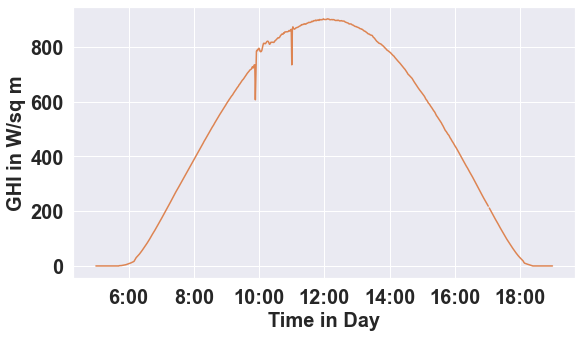

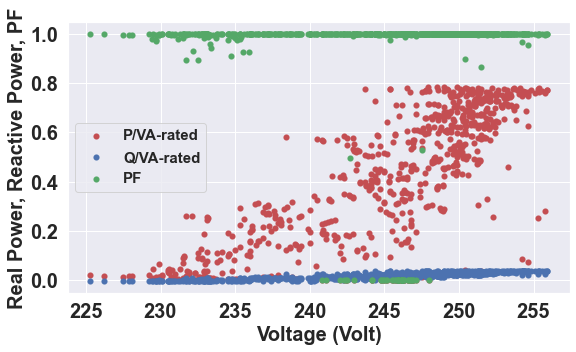

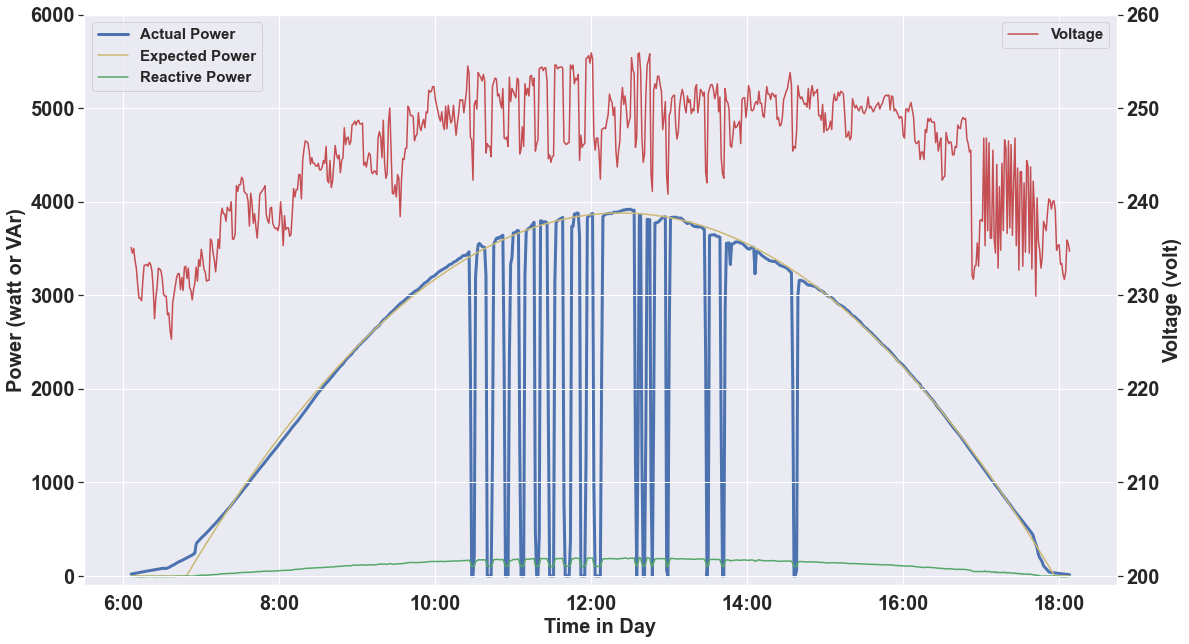

Analyzing sample number 2


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:693: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2019-09-18           True               22.620074   

   expected energy generated (kWh) estimation method tripping response  \
0                         26.78166           Polyfit               Yes   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                    4.161585           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

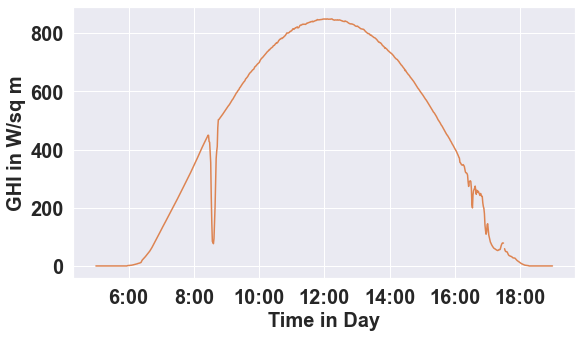

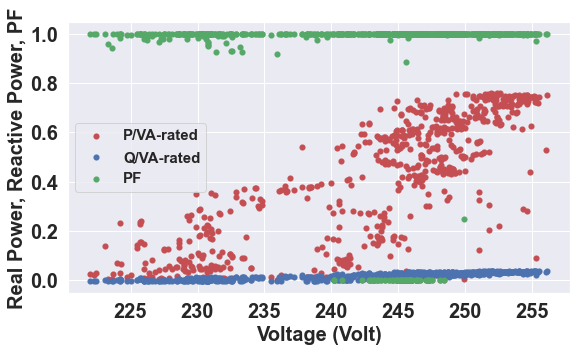

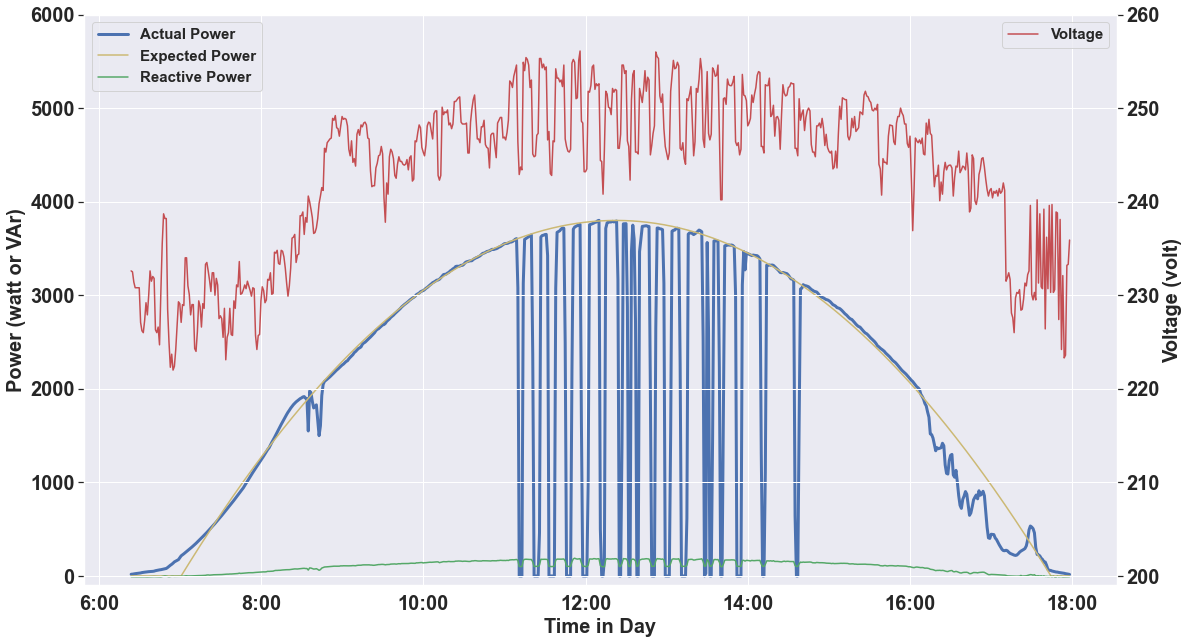

Analyzing sample number 3


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:693: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2019-09-26           True               19.307878   

   expected energy generated (kWh) estimation method tripping response  \
0                        27.283818           Polyfit               Yes   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                     7.97594           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

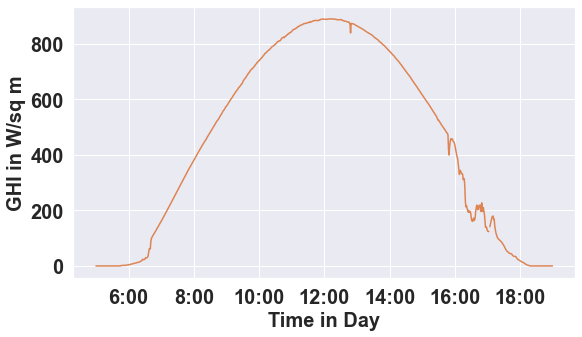

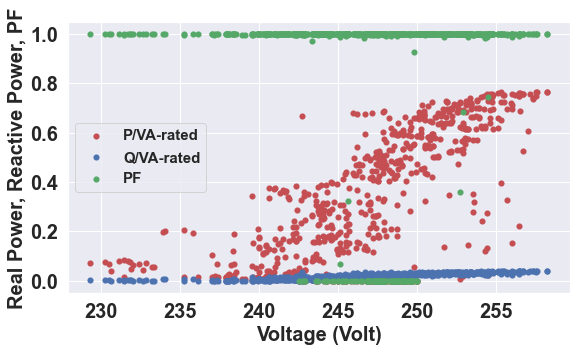

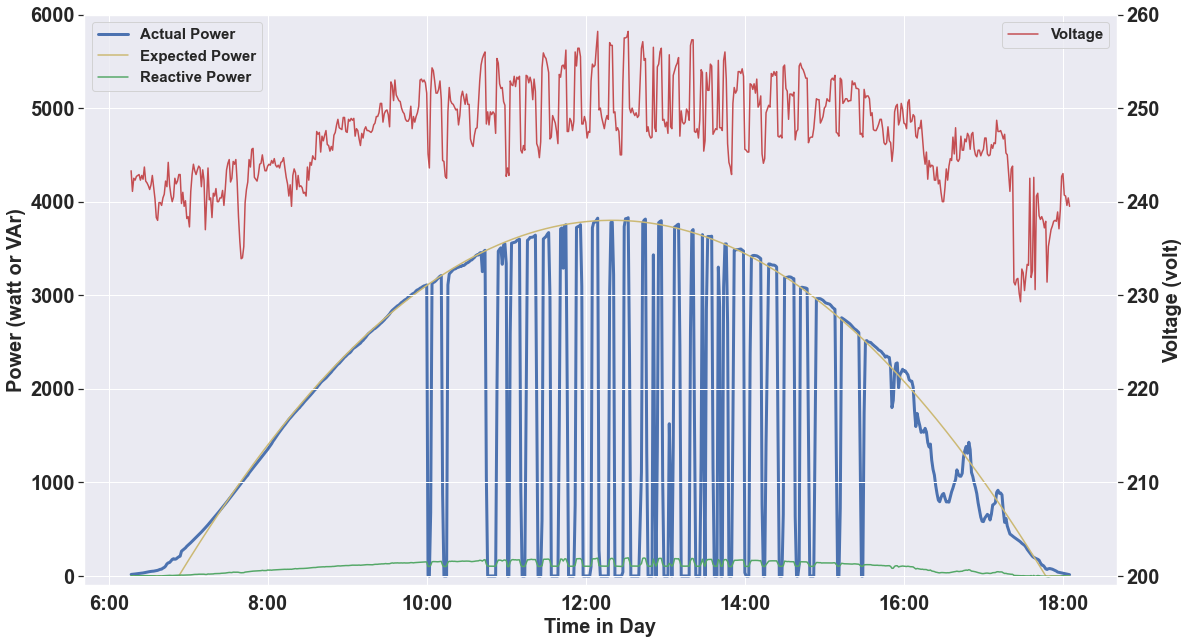

Analyzing sample number 4


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:693: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2019-09-29           True               19.000831   

   expected energy generated (kWh) estimation method tripping response  \
0                        27.441162           Polyfit               Yes   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                    8.440331           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

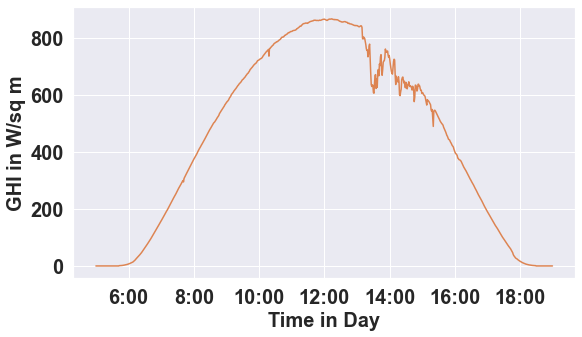

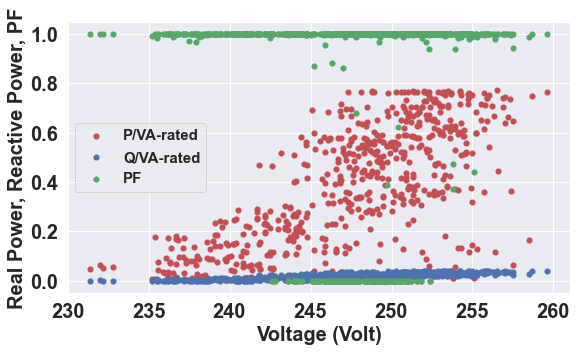

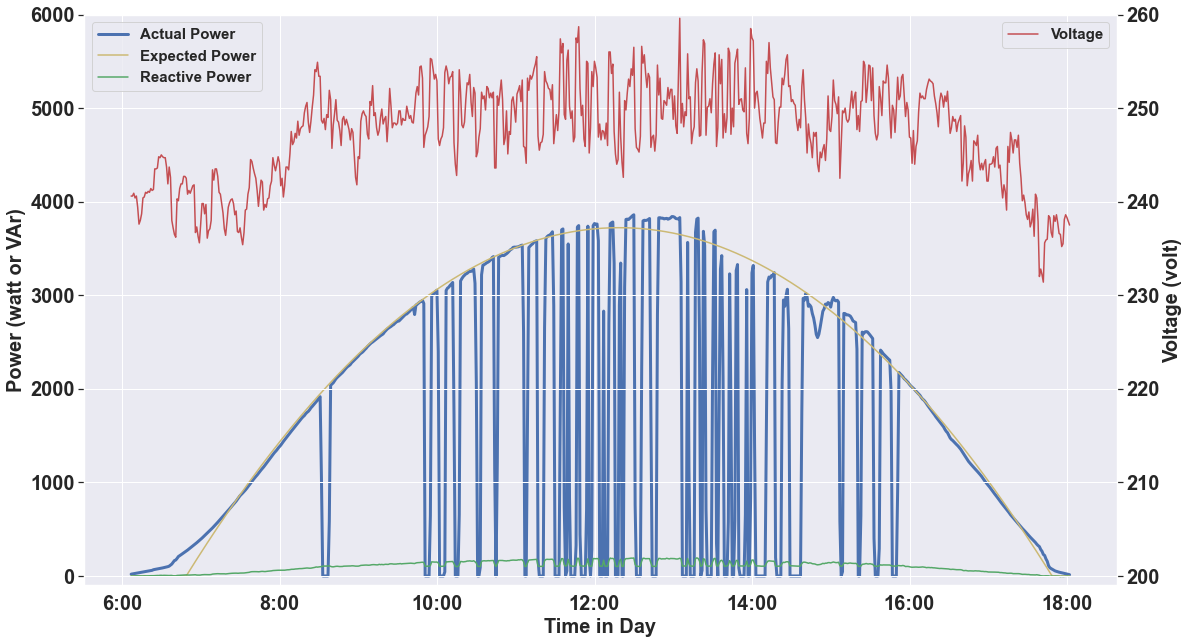

Analyzing sample number 5


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:693: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2019-10-03           True               13.177723   

   expected energy generated (kWh) estimation method tripping response  \
0                        26.969785           Polyfit               Yes   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                   13.792062           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

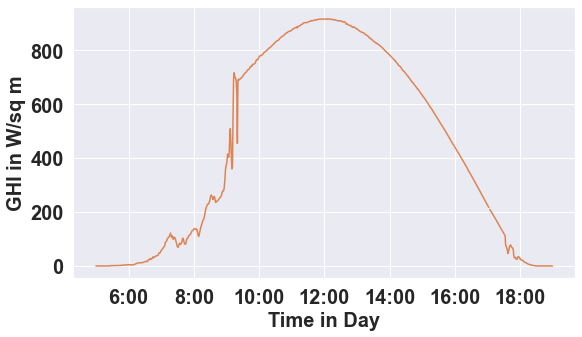

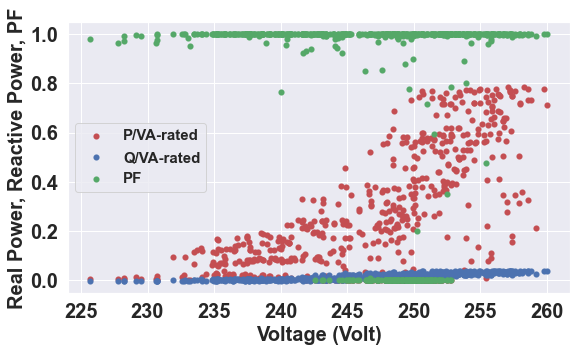

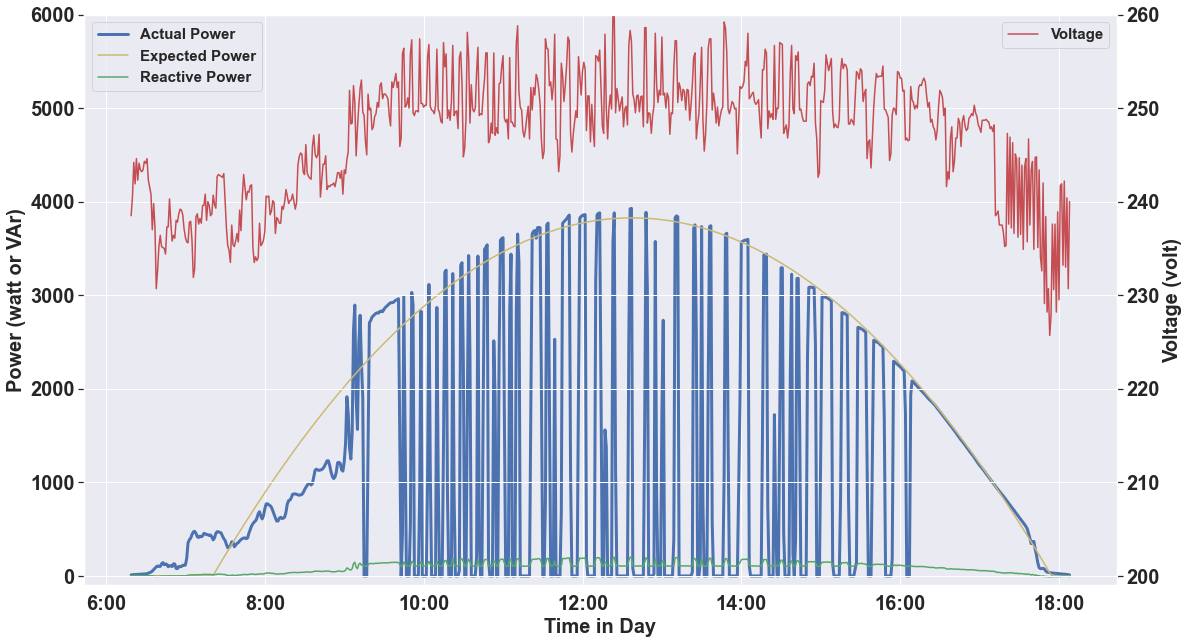

Analyzing sample number 6


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:693: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2019-10-29           True               22.662687   

   expected energy generated (kWh) estimation method tripping response  \
0                        32.652676           Polyfit               Yes   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                    9.989989           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

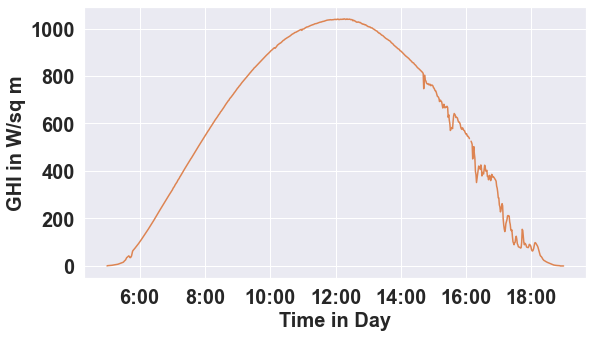

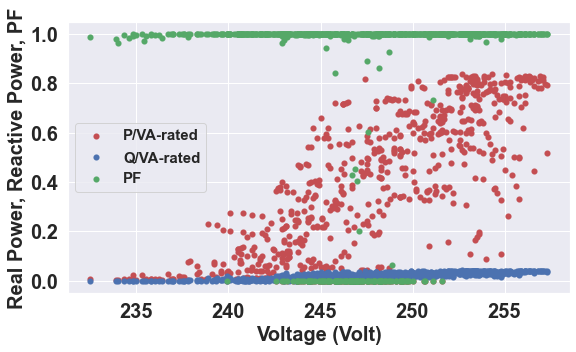

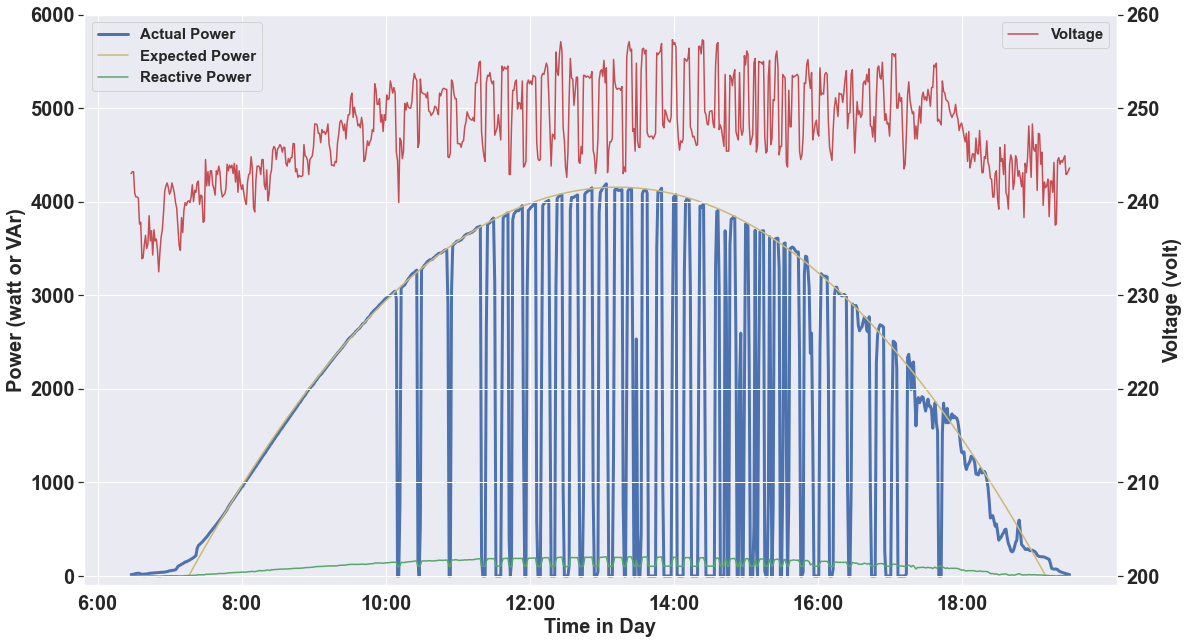

Analyzing sample number 7


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2019-12-28           True               33.132491   

   expected energy generated (kWh) estimation method tripping response  \
0                        33.132491           Polyfit              None   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                           0           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

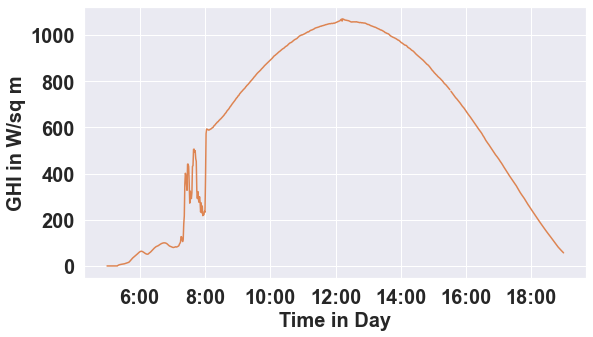

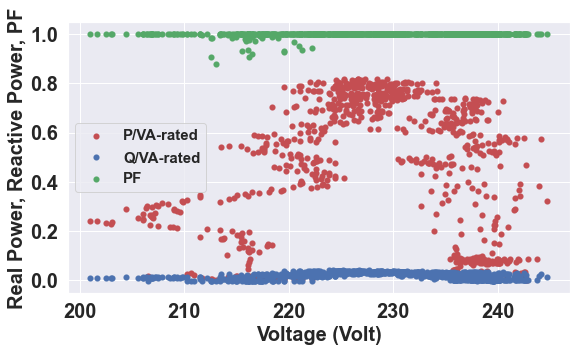

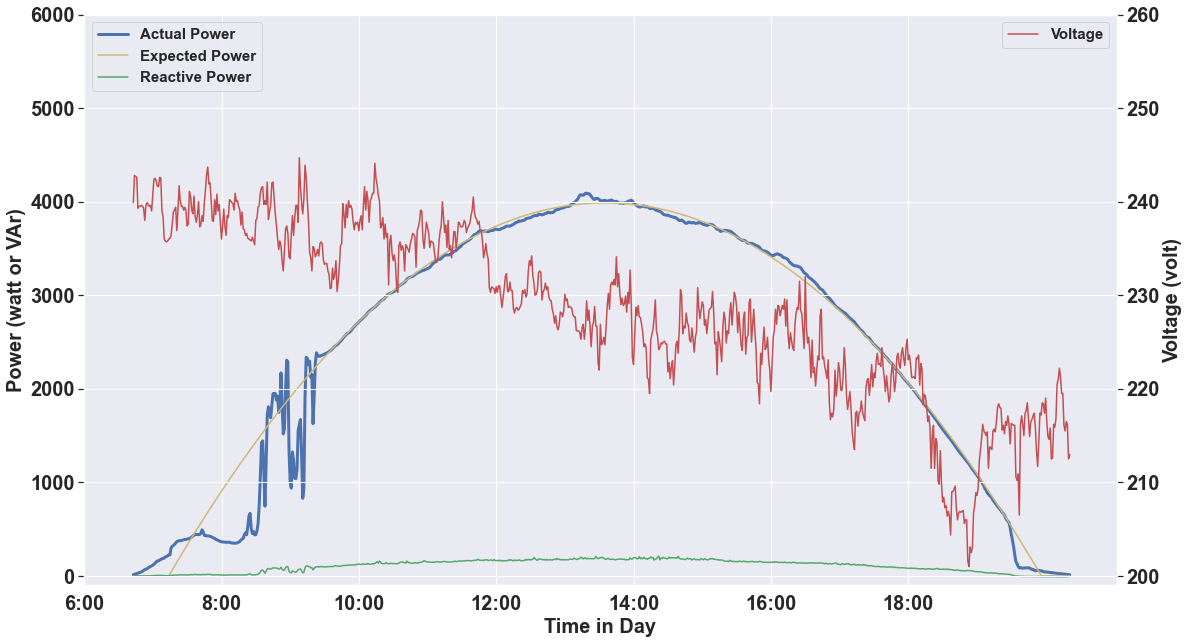

Analyzing sample number 8


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:693: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2020-01-17           True               24.202501   

   expected energy generated (kWh) estimation method tripping response  \
0                        36.557788           Polyfit               Yes   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                   12.355287           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

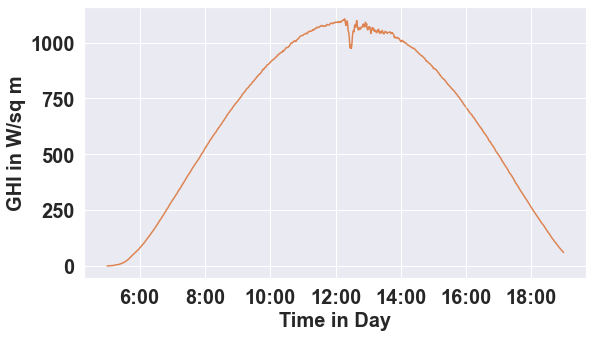

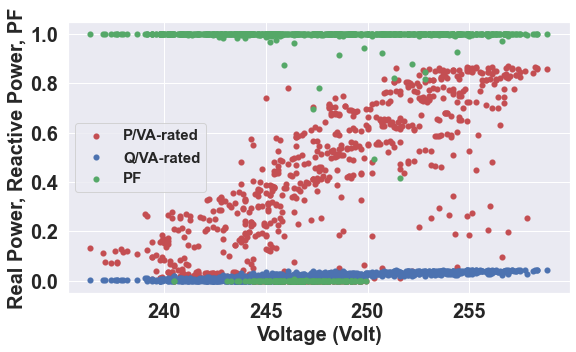

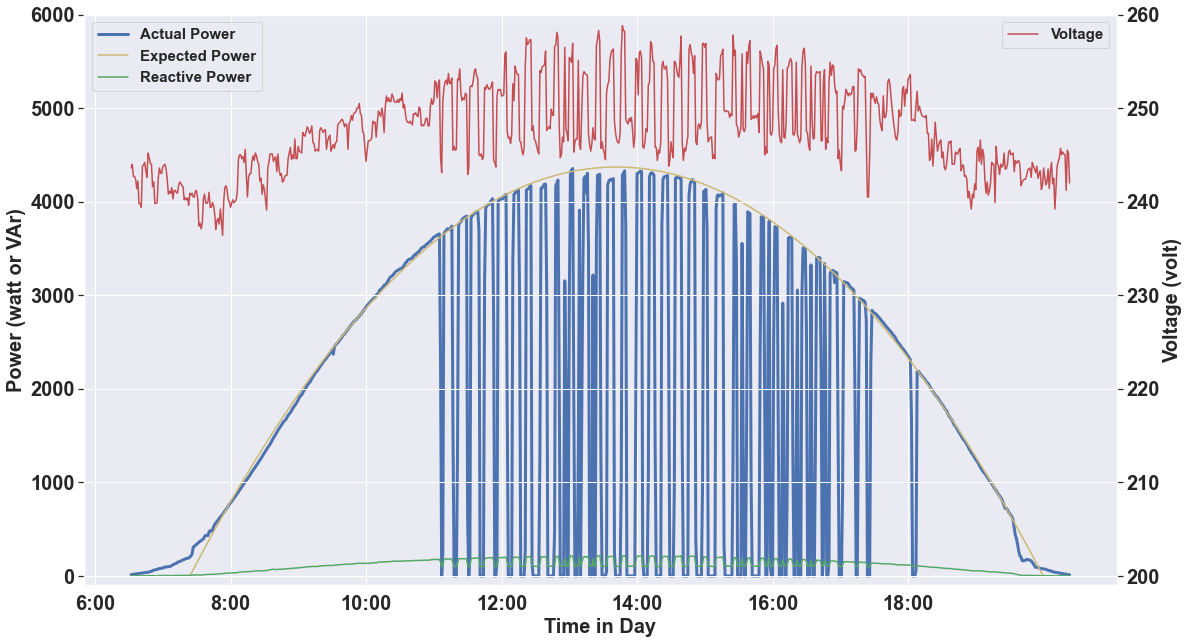

Analyzing sample number 9


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2020-02-23           True                31.21321   

   expected energy generated (kWh) estimation method tripping response  \
0                         31.21321           Polyfit              None   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                           0           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

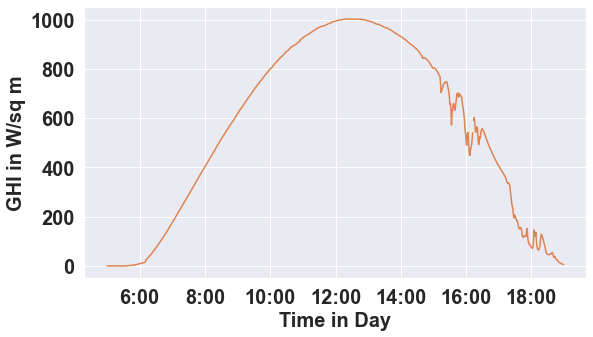

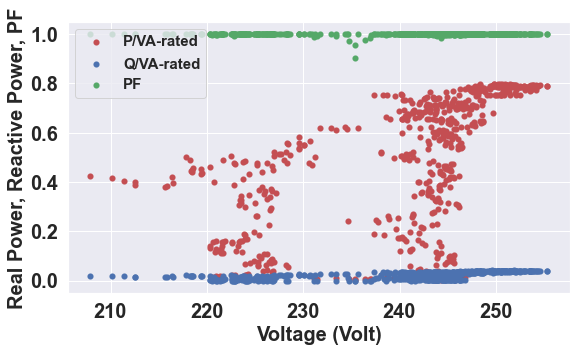

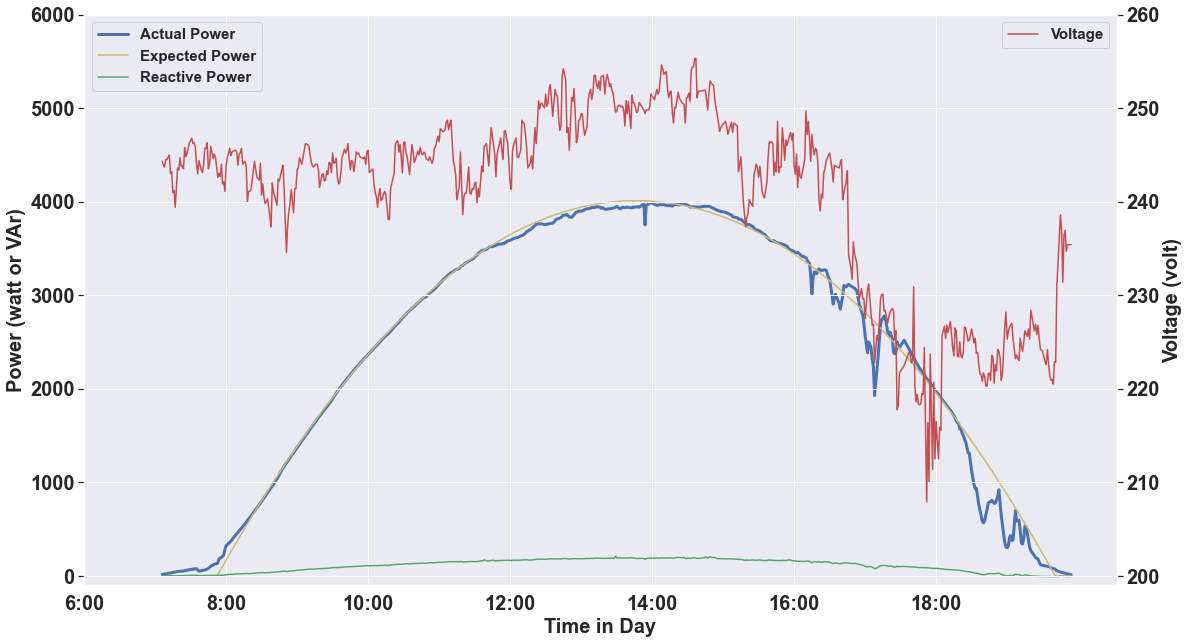

Analyzing sample number 10


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:693: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2020-03-03           True               12.197463   

   expected energy generated (kWh) estimation method tripping response  \
0                        12.433498           Polyfit               Yes   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                    0.236035           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

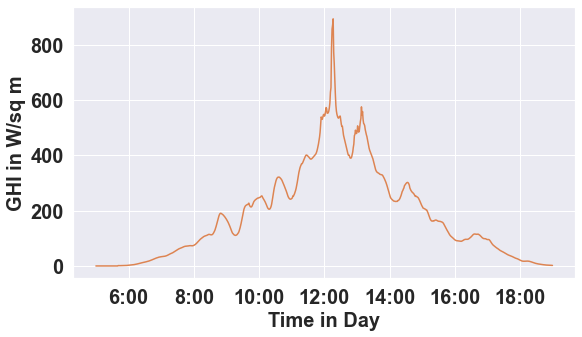

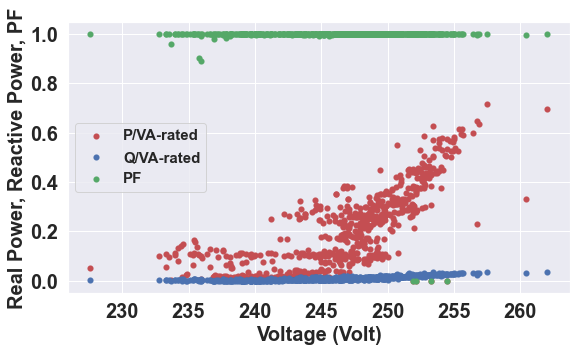

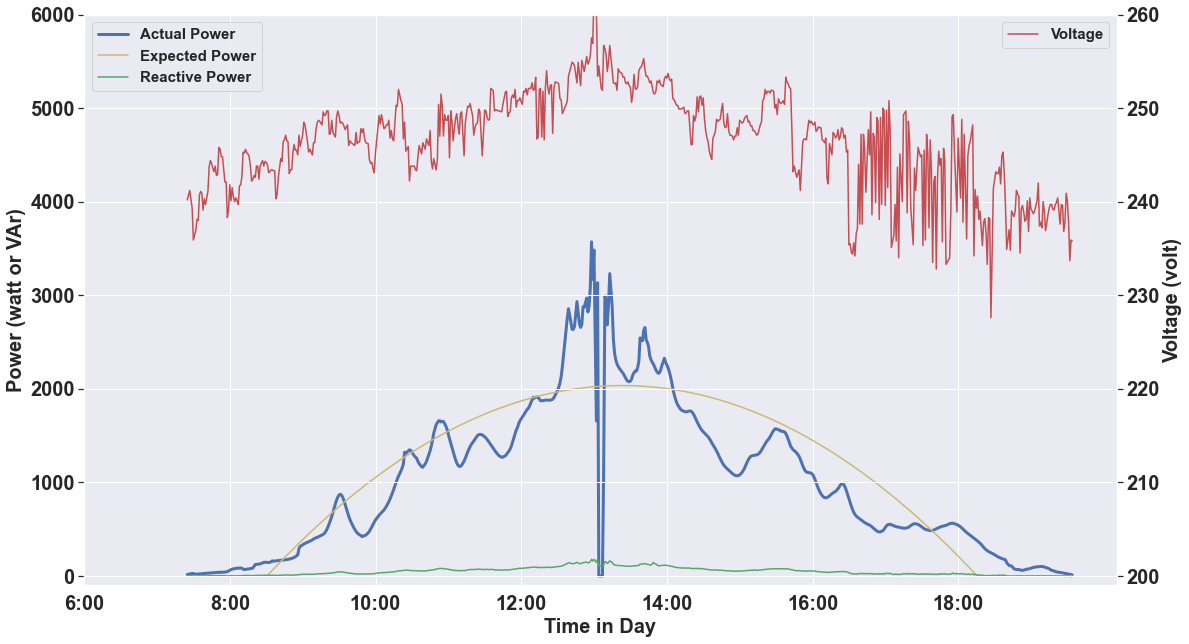

Analyzing sample number 11


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2020-03-10           True               28.867301   

   expected energy generated (kWh) estimation method tripping response  \
0                        28.867301           Polyfit              None   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                           0           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

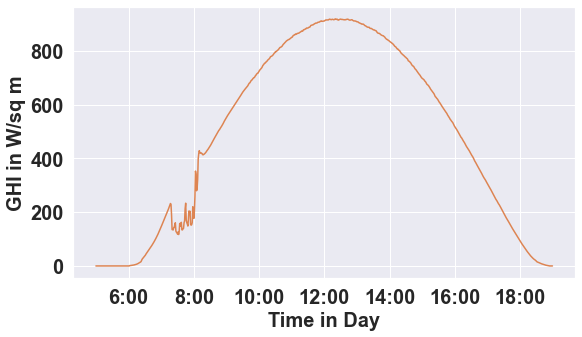

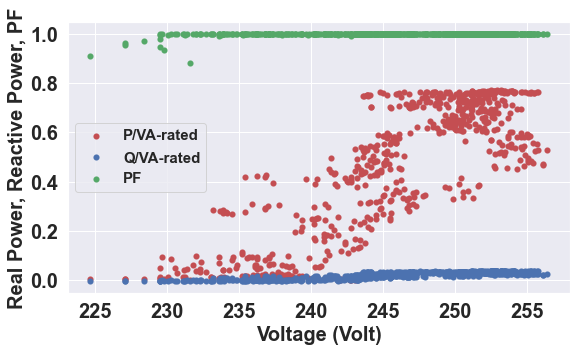

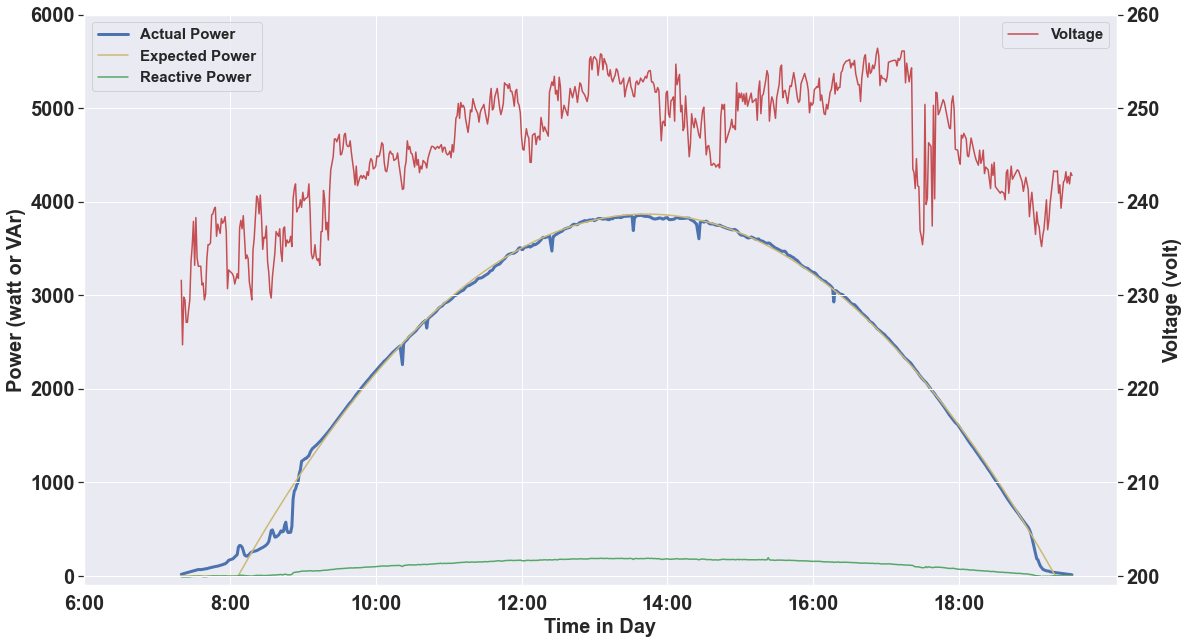

Analyzing sample number 12


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:693: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2020-02-13           True               31.158115   

   expected energy generated (kWh) estimation method tripping response  \
0                        31.664634           Polyfit               Yes   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                    0.506519           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

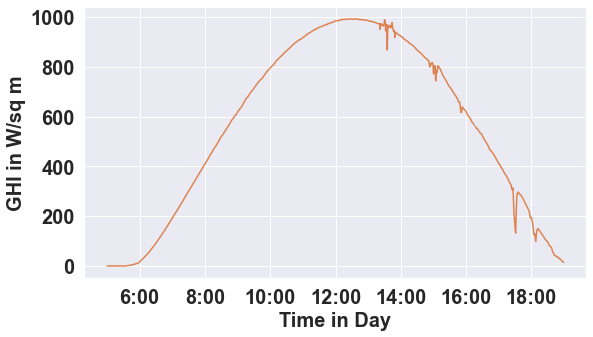

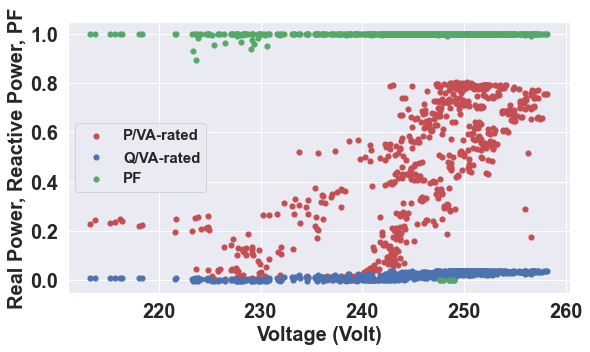

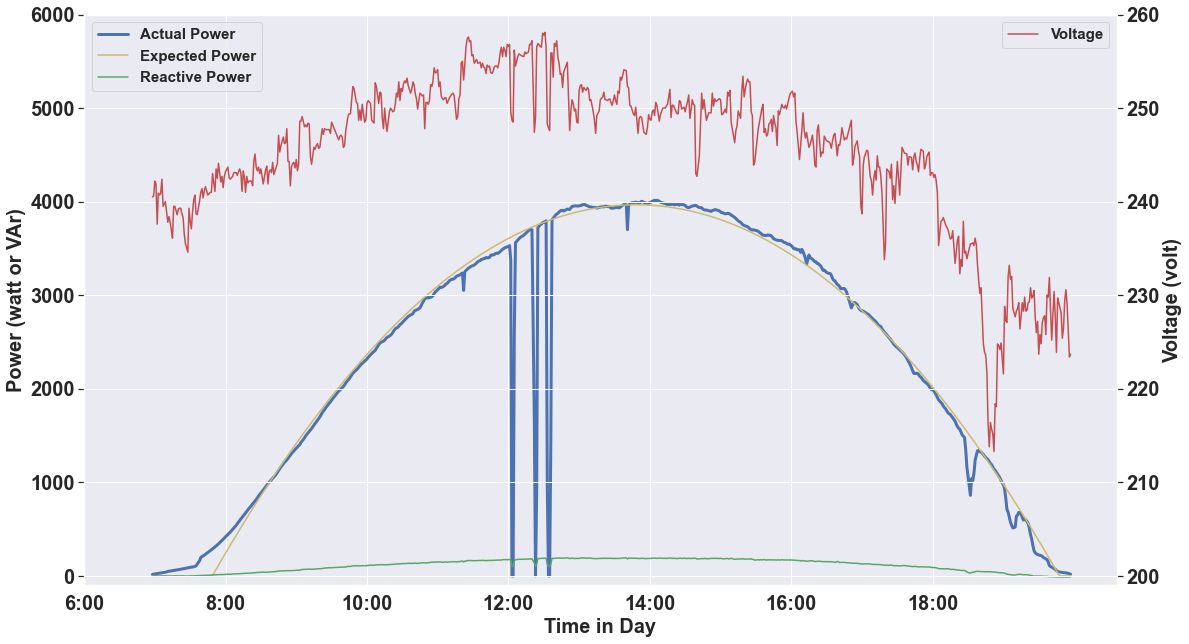

Analyzing sample number 13


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:693: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2020-03-14           True               26.148262   

   expected energy generated (kWh) estimation method tripping response  \
0                        28.670189           Polyfit               Yes   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                    2.521927           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

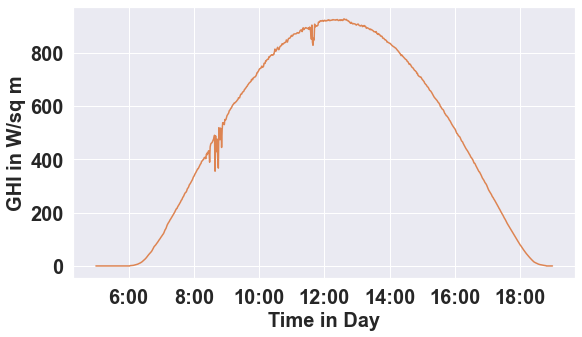

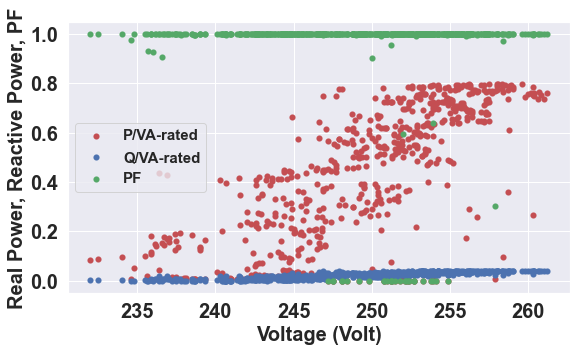

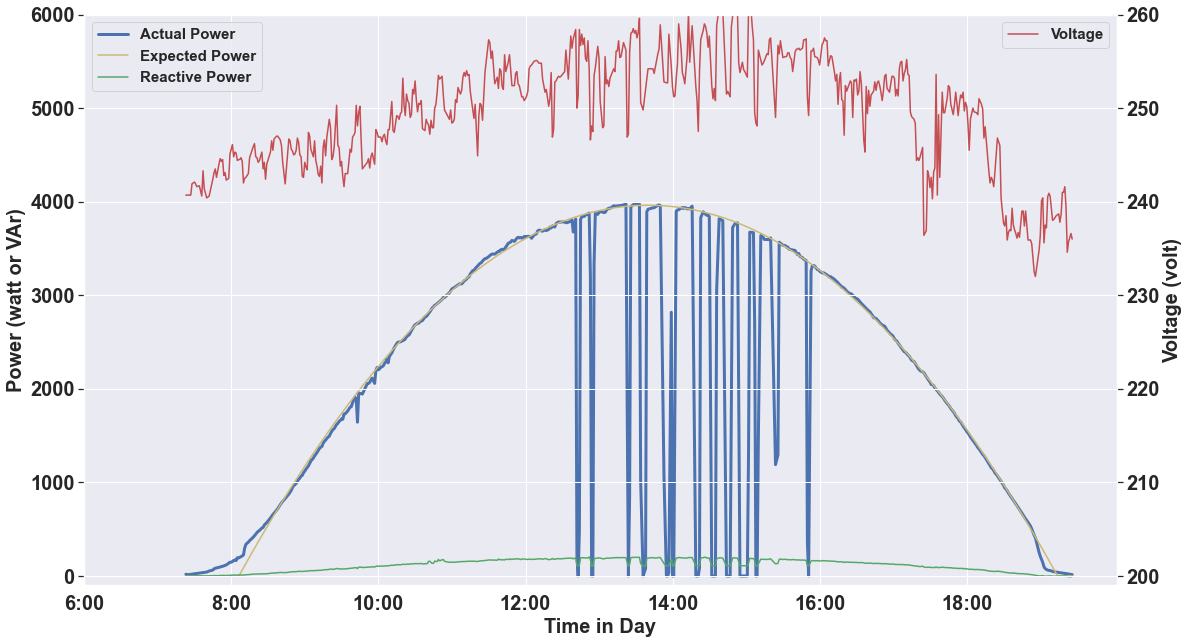

Analyzing sample number 14


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:693: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


c_id        date  clear sky day  energy generated (kWh)  \
0  1317822057  2020-04-08           True               22.847464   

   expected energy generated (kWh) estimation method tripping response  \
0                        23.018588           Polyfit               Yes   

   tripping curtailment (kWh) V-VAr response  V-VAr curtailment (kWh)  \
0                    0.171123           None                      0.0   

  V-Watt response  V-Watt curtailment (kWh)  
0            None                         0

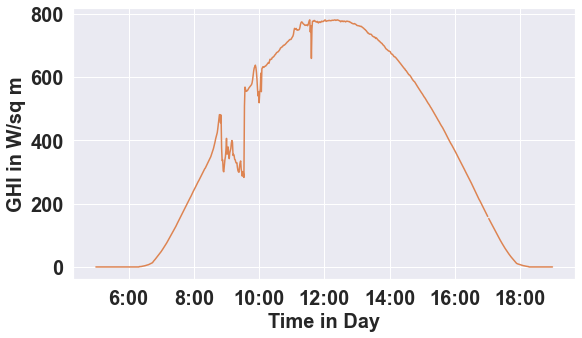

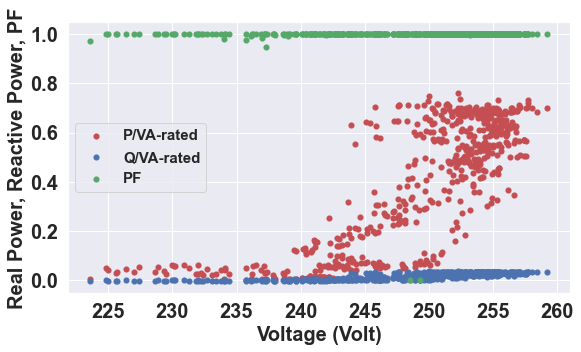

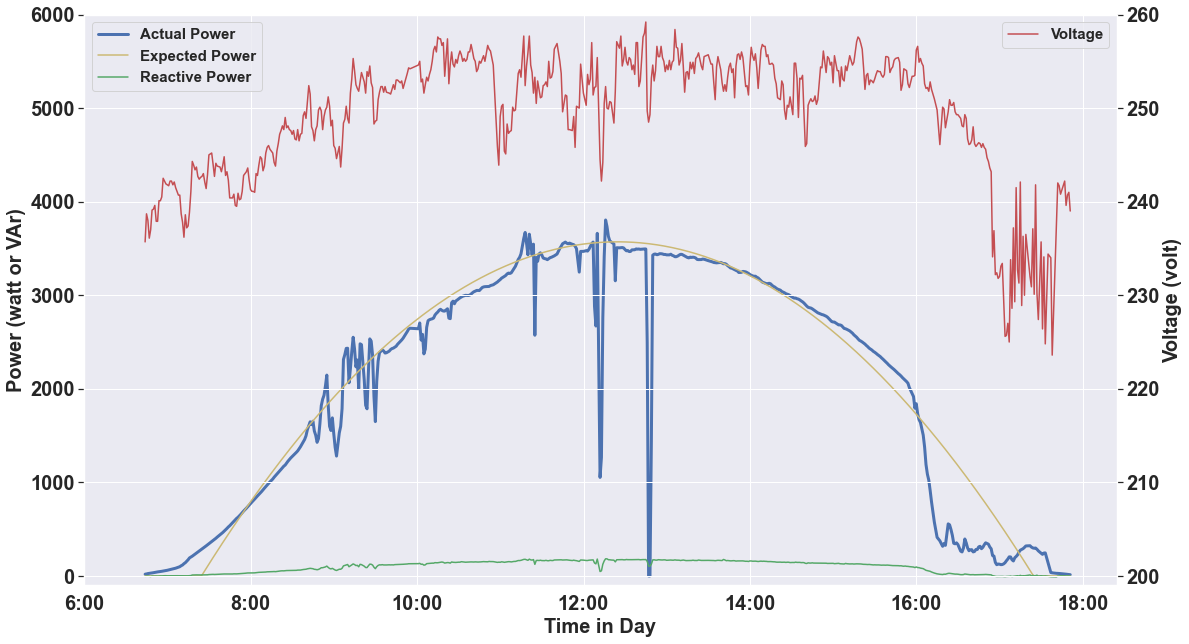

In [40]:
# MODIFY THE FILE_PATH ACCORDING TO YOUR DIRECTORY FOR SAVING THE DATA FILES.
# file_path = r"/Users/samhan/Downloads/data" #for running in Samhan's laptop
file_path = r"C:\Users\samha\Documents\CANVAS\data" #for running in TETB CEEM09 computer

#These samples represent (consecutively) tripping curtailment in a non clear sky day, tripping curtailment in a clear sky 
#day, vvar curtailment, vwatt curtailment, incomplete datasample, and sample without curtailment.
for i in range(1,15): 
    sample_number = 'csd_conflict_{}'.format(i)
    print('Analyzing sample number {}'.format(i))
    data_file = '/data_sample_{}.csv'.format(sample_number)
    ghi_file = '/ghi_sample_{}.csv'.format(sample_number)

    curtailment_calculation.compute(file_path, data_file, ghi_file)

# MESSY BELOW

In [22]:
i = 2
sample_number = 'csd_conflict_{}'.format(i)
print('Analyzing sample number {}'.format(i))
data_file = '/data_sample_{}.csv'.format(sample_number)

data = pd.read_csv(file_path + data_file, index_col = 0)
data.index = pd.to_datetime(data.index)

Analyzing sample number 2


In [23]:
data

c_id  energy        power  reactive_power  \
Timestamp                                                                    
2019-09-18 08:55:55+09:30  1317822057  132033  2200.550000            6248   
2019-09-18 08:56:55+09:30  1317822057  132741  2212.350000            6271   
2019-09-18 12:41:55+09:30  1317822057  224136  3735.600000           10801   
2019-09-18 12:42:55+09:30  1317822057  224285  3738.083333           10803   
2019-09-18 12:43:55+09:30  1317822057  224492  3741.533333           10903   
...                               ...     ...          ...             ...   
2019-09-18 20:21:55+09:30  1317822057     -97    -1.616667            5793   
2019-09-18 20:22:55+09:30  1317822057     -97    -1.616667            5786   
2019-09-18 20:23:55+09:30  1317822057     -96    -1.600000            5778   
2019-09-18 20:24:55+09:30  1317822057     -98    -1.633333            5836   
2019-09-18 20:25:55+09:30  1317822057     -96    -1.600000            5805   

                           voltage  duration  
Timestamp                                     
2019-09-18 08:55:55+09:30    247.9        60  
2019-09-18 08:56:55+09:30    247.8        60  
2019-09-18 12:41:55+09:30    250.6        60  
2019-09-18 12:42:55+09:30    252.0        60  
2019-09-18 12:43:55+09:30    254.0        60  
...                            ...       ...  
2019-09-18 20:21:55+09:30    237.5        60  
2019-09-18 20:22:55+09:30    239.1        60  
2019-09-18 20:23:55+09:30    237.3        60  
2019-09-18 20:24:55+09:30    237.9        60  
2019-09-18 20:25:55+09:30    239.3        60  

[1435 rows x 6 columns]

In [25]:
site_details, unique_cids= file_processing.input_general_files(file_path)
summary_all_samples = pd.DataFrame()

data = pd.read_csv(file_path + data_file)
pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
data['Timestamp'] = pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
data.set_index('Timestamp', inplace=True)

size_is_ok = file_processing.check_data_size(data)
if not size_is_ok:
    print('Cannot analyze this sample due to incomplete data.')
else:
    ghi = pd.read_csv(file_path + ghi_file, index_col = 0)
    ghi.index = pd.to_datetime(ghi.index)

    c_id = data['c_id'][0]
    date = str(data.index[0])[:10]

    data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data, unique_cids)
    data_site = file_processing.resample_in_minute(data_site)

    #check the expected power using polyfit
    data_site, polyfit, is_good_polyfit_quality = polyfit_f.check_polyfit(data_site, ac_cap)
    #data_site, a, is_good_polyfit_quality = check_polyfit_constrained(data_site, ac_cap)

    is_clear_sky_day = clear_sky_day.check_clear_sky_day(date, file_path)
    tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
    energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:693: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,y)[0]


In [38]:
ghi = pd.read_csv(file_path + ghi_file, index_col = 0)

In [39]:
ghi

Empty DataFrame
Columns: [sl, Station Number, Year Month Day Hours Minutes in YYYY, MM, DD, HH24, MI format in Local standard time, Mean global irradiance (over 1 minute) in W/sq m, Minimum 1 second global irradiance (over 1 minute) in W/sq m, Maximum 1 second global irradiance (over 1 minute) in W/sq m, Standard deviation of global irradiance (over 1 minute) in W/sq m, Uncertainty in mean global irradiance (over 1 minute) in W/sq m, Mean direct irradiance (over 1 minute) in W/sq m, Minimum 1 second direct irradiance (over 1 minute) in W/sq m, Maximum 1 second direct irradiance (over 1 minute) in W/sq m, Standard deviation of direct irradiance (over 1 minute) in W/sq m, Uncertainty in mean direct irradiance (over 1 minute) in W/sq m, Mean diffuse irradiance (over 1 minute) in W/sq m, Minimum 1 second diffuse irradiance (over 1 minute) in W/sq m, Maximum 1 second diffuse irradiance (over 1 minute) in W/sq m, Standard deviation of diffuse irradiance (over 1 minute) in W/sq m, Uncertainty in mean diffuse irradiance (over 1 minute) in W/sq m, Mean terrestrial irradiance (over 1 minute) in W/sq m, Minimum 1 second terrestrial irradiance (over 1 minute) in W/sq m, Maximum 1 second terrestrial irradiance (over 1 minute) in W/sq m, Standard deviation of terrestrial irradiance (over 1 minute) in W/sq m, Uncertainty in mean terrestrial irradiance (over 1 minute) in W/sq m, Mean direct horizontal irradiance (over 1 minute) in W/sq m, Minimum 1 second direct horizontal irradiance (over 1 minute) in W/sq m, Maximum 1 second direct horizontal irradiance (over 1 minute) in W/sq m, Standard deviation of direct horizontal irradiance (over 1 minute) in W/sq m, Uncertainty in mean direct horizontal irradiance (over 1 minute) in W/sq m, Sunshine-seconds-96 (duration of DNI exceeding 96 W/sq m over 1 minute) in seconds, Sunshine-seconds-120 (duration of DNI exceeding 120 W/sq m over 1 minute) in seconds, Sunshine-seconds-144 (duration of DNI exceeding 144 W/sq m over 1 minute) in seconds, Zenith distance in degrees]
Index: []

[0 rows x 36 columns]

In [26]:
data_site

c_id  energy      power  reactive_power  voltage  \
ts                                                                            
2019-09-18 06:23:55  1317822057    1079  17.983333       -7.166667    232.6   
2019-09-18 06:24:55  1317822057    1147  19.116667       -7.583333    232.5   
2019-09-18 06:25:55  1317822057    1319  21.983333       -8.916667    231.4   
2019-09-18 06:26:55  1317822057    1460  24.333333       -8.066667    230.8   
2019-09-18 06:27:55  1317822057    1581  26.350000       -8.100000    230.8   
...                         ...     ...        ...             ...      ...   
2019-09-18 17:53:55  1317822057    1703  28.383333       -8.266667    223.3   
2019-09-18 17:54:55  1317822057    1467  24.450000       -8.766667    223.6   
2019-09-18 17:55:55  1317822057    1348  22.466667       -7.600000    233.2   
2019-09-18 17:56:55  1317822057    1159  19.316667       -7.800000    233.3   
2019-09-18 17:57:55  1317822057     964  16.066667       -6.966667    235.9   

                     duration         va        pf  power_relative  \
ts                                                                   
2019-09-18 06:23:55        60  19.358755  0.928951        0.003597   
2019-09-18 06:24:55        60  20.565843  0.929535        0.003823   
2019-09-18 06:25:55        60  23.722856  0.926673        0.004397   
2019-09-18 06:26:55        60  25.635566  0.949202        0.004867   
2019-09-18 06:27:55        60  27.566873  0.955857        0.005270   
...                       ...        ...       ...             ...   
2019-09-18 17:53:55        60  29.562669  0.960107        0.005677   
2019-09-18 17:54:55        60  25.974159  0.941320        0.004890   
2019-09-18 17:55:55        60  23.717317  0.947268        0.004493   
2019-09-18 17:56:55        60  20.832033  0.927258        0.003863   
2019-09-18 17:57:55        60  17.512059  0.917463        0.003213   

                     power_expected  power_expected_linear  
ts                                                          
2019-09-18 06:23:55             0.0              17.983333  
2019-09-18 06:24:55             0.0              19.116667  
2019-09-18 06:25:55             0.0              21.983333  
2019-09-18 06:26:55             0.0              24.333333  
2019-09-18 06:27:55             0.0              26.350000  
...                             ...                    ...  
2019-09-18 17:53:55             0.0              28.383333  
2019-09-18 17:54:55             0.0              24.450000  
2019-09-18 17:55:55             0.0              22.466667  
2019-09-18 17:56:55             0.0              19.316667  
2019-09-18 17:57:55             0.0              16.066667  

[693 rows x 11 columns]

In [32]:
date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
data_site_certain_date = data_site.loc[data_site.index.date == date_dt]
ghi = ghi.loc[ghi.index.date == date_dt]
data_site = data_site_certain_date

# Manipulations on the original data_site to match the GHI
dummy = data_site.copy()
dummy.index = dummy.index.round('min')   # round the timestamp to nearest minute to match with the GHI
dummy = dummy.groupby(level = 0 ).mean()  # average same timestamp values that fall under the same minute category

data_site_complete = pd.DataFrame (index = ghi.index)  # create a data_site_complete with complete set of dates to match with GHI
data_site_complete = data_site_complete.join(dummy)

# Required conditions for V-VAr curtailment
VAR_T = 100  # min VAr condition 
DURATION = 60  # we have normalized all t-stamps to 60 second previously
va_criteria = data_site_complete['va'] >= (ac_cap - VAR_T)  # this is to ensure inverter VA is close to its rated capacity (this eliminates the instances of tripping)
var_criteria = abs(data_site_complete['reactive_power'].values) > VAR_T  # this is to ensure inverter is injecting/absorbing at least 100 vars
curt_criteria = va_criteria & var_criteria  # curtailment criteria that satisfies the two criteria above

data_curtailment = data_site_complete[curt_criteria]  # investigate curtailment only for the instances which satisfy above criteria 
ghi_curtailment = ghi[curt_criteria]

is_inject_or_absorb = (data_site['reactive_power'].abs() > 100).any()
if not is_inject_or_absorb:
    vvar_response = 'None'
else:
    # OBTAIN REACTIVE POWER LEVEL IN %
    data_site['q_level_percent'] = data_site['reactive_power'] / ac_cap * 100

    # RECHECK AND CORRECT THE POLARITY
    filter_more_235 = data_site['voltage'] > 235
    polarity_wrong = data_site.loc[filter_more_235, 'q_level_percent'].sum() > 0
    if polarity_wrong:
        data_site.loc[filter_more_235, 'q_level_percent'] = - data_site.loc[filter_more_235, 'q_level_percent']

    # CHECK HOW IT LOOKS LIKE VVAR CURVE

    #    OBTAIN THE LINEAR EQ
    #      Filter out the zeros and the minimum q level
    minimum_q_level = data_site['q_level_percent'].min()
    ERROR_PERCENT = 5
    filter_zero = data_site['q_level_percent'] < - ERROR_PERCENT
    filter_minimum = data_site['q_level_percent'] > minimum_q_level + ERROR_PERCENT
    filter_for_linreg = filter_zero & filter_minimum

    data_site['q_level_forreg'] = data_site.loc[filter_for_linreg, 'q_level_percent']

    try:
        #      Perform linear regression
        from sklearn.linear_model import LinearRegression

        X = np.array(data_site.loc[filter_for_linreg, 'voltage']).reshape(-1, 1)  # values converts it into a numpy array
        Y = np.array(data_site.loc[filter_for_linreg, 'q_level_percent']).reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
        all_voltage = np.array(data_site['voltage']).reshape(-1, 1)

        linear_regressor = LinearRegression()  # create object for the class
        linear_regressor.fit(X, Y)  # perform linear regression
        data_site['q_level_regresult'] = linear_regressor.predict(all_voltage)  # make predictions

        data_site.loc[data_site['q_level_regresult'] > 0, 'q_level_regresult'] = float('nan')
        data_site.loc[data_site['q_level_regresult'] < minimum_q_level, 'q_level_regresult'] = float('nan')

        #    GET V3, V4
        V3 = (data_site.loc[data_site['q_level_regresult'] == data_site['q_level_regresult'].max(), 'voltage']).mean()

        V4 = (data_site.loc[data_site['q_level_regresult'] == data_site['q_level_regresult'].min(), 'voltage']).mean()

        BUFFER_VAR_PERCENT = 15

        decreasing_var = data_site.loc[data_site['q_level_regresult'].notna(), ['voltage', 'q_level_percent', 'q_level_regresult']]
        decreasing_var['upper_buffer'] = decreasing_var['q_level_regresult'] + BUFFER_VAR_PERCENT
        decreasing_var['lower_buffer'] = decreasing_var['q_level_regresult'] - BUFFER_VAR_PERCENT

        #    CHECK PERCENTAGE COMPLIANCE
        is_low_ok = decreasing_var['lower_buffer'] < decreasing_var['q_level_percent']
        is_upp_ok = decreasing_var['q_level_percent'] < decreasing_var['upper_buffer']
        decreasing_var['is_in_buffer_range'] = is_low_ok & is_upp_ok
        count_in_buffer_range = decreasing_var['is_in_buffer_range'].values.sum() #count true in a col

        percentage_in_buffer_range = float(count_in_buffer_range) / float(len(decreasing_var.index)) * 100
        PERCENTAGE_THRESHOLD = 80

        # This is according to the combined range from SAPN TS-129, AS/NZS 4777-2015, ENA recommendation - 2019, and
        # AS/NZS 4777 - 2020 (Australia B - small sytems) with 1.5 margin to take random error into account.
        V3_LOWER_LIMIT = 233.5
        V3_UPPER_LIMIT = 251.5
        V4_LOWER_LIMIT = 251.5
        V4_UPPER_LIMIT = 269.5

        compliance_percent = percentage_in_buffer_range > PERCENTAGE_THRESHOLD
        compliance_v3 = V3_LOWER_LIMIT < V3 < V3_UPPER_LIMIT 
        compliance_v4 = V4_LOWER_LIMIT < V4 < V4_UPPER_LIMIT 

        if compliance_percent & compliance_v3 & compliance_v4:
            vvar_response = 'Yes'
        else:
            vvar_response = 'None'

    except:
        vvar_response = 'None'

C:\Users\samha\AppData\Local\Temp\ipykernel_16880\1186483689.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ghi_curtailment = ghi[curt_criteria]


In [33]:
# POLYFIT METHOD TO CALCULATE THE MAX POWER WITHOUT CURTAILMENT, UNAPPLICABLE IN NON CLEAR SKY DAYS
circuit_day_data = data_site_complete.reset_index(level=0)
circuit_day_data.rename(columns = {'timestamp':'ts'}, inplace = True)
circuit_day_data['ts'] = circuit_day_data['ts'].astype(str)

df = circuit_day_data
df = vwatt_curt.slice_end_off_df(df) # REMOVES LAST TAIL AND HEAD OF DATA AFTER IT CHANGES TO ZERO WATTS, BUT KEEPS ZERO WATT VALUES IN THE MIDDLE OF THE LIST

In [36]:
data_site_complete

Empty DataFrame
Columns: [c_id, energy, power, reactive_power, voltage, duration, va, pf, power_relative, power_expected, power_expected_linear]
Index: []

In [27]:
vvar_response, vvar_curt_energy, data_site = vvar_curt.check_vvar_curtailment(c_id, date, data_site, ghi, ac_cap, dc_cap, EFF_SYSTEM, is_clear_sky_day)

C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\vvar_curt.py:163: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ghi_curtailment = ghi[curt_criteria]


AttributeError: 'NoneType' object has no attribute 'loc'

In [ ]:
data_site, vwatt_response, vwatt_curt_energy = vwatt_curt.check_vwatt_curtailment(data_site, date, is_good_polyfit_quality, file_path, ac_cap, is_clear_sky_day)

energy_generated_expected, estimation_method = energy_calculation.check_energy_expected(energy_generated, tripping_curt_energy, vvar_curt_energy, vwatt_curt_energy, is_clear_sky_day)